In [33]:
import tqdm
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
from torch.utils.data import DataLoader
from torch.nn.functional import normalize
from src.modeling.network.backbone import ResNet1D
from src.data.transform import generate_signal_and_label
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, multilabel_confusion_matrix

In [6]:
MAX_LEN = 16284
BATCH_SIZE = 16
DEVICE = 'cuda'
PATH = 'checkpoints/best_model.pkl'

def img_label_to_tensor(examples):
    if 'image' in examples.keys():
        examples['image'] = [np.pad(img, pad_width=(0, MAX_LEN - len(img))) if len(img) < MAX_LEN else img[:MAX_LEN] for img in examples['image']]
        examples['image'] = [torch.unsqueeze(normalize(torch.tensor(img).float(), dim=0), dim=0) for img in examples['image']]

        examples['label'] = torch.tensor(examples['label'])
        return examples

In [3]:
test_ds = load_dataset("mwritescode/slither-audited-smart-contracts", 'big-multilabel', split='test', ignore_verifications=True)
test_ds = test_ds.filter(lambda elem: elem['bytecode'] != '0x')
test_ds = test_ds.map(generate_signal_and_label, remove_columns=['address', 'source_code', 'bytecode', 'slither'])
test_ds.set_transform(img_label_to_tensor)

Reusing dataset slither_audited_smart_contracts (C:\Users\Martina\.cache\huggingface\datasets\mwritescode___slither_audited_smart_contracts\big-multilabel\1.1.0\4cf503b59ce9d3157914e47f6253de773b7ab828f46642685d4b470b88ca1f13)
100%|██████████| 15921/15921 [00:05<00:00, 2757.70ex/s]


In [4]:
loader_test = DataLoader(test_ds, batch_size=BATCH_SIZE)

In [ ]:
model = ResNet1D(num_classes=5)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE)
model.eval()

In [18]:
total_preds = []
total_gt = []
for batch in tqdm.tqdm(loader_test):
    images = batch['image'].to(DEVICE)
    preds = model(images)
    preds = (preds >= 0.0).float().cpu().numpy()
    total_preds.append(preds)
    total_gt.append(batch['label'])

y_pred = np.concatenate(total_preds, axis=0)
y_true = np.concatenate(total_gt, axis=0)

100%|██████████| 996/996 [05:44<00:00,  2.89it/s]


In [30]:
LABEL_NAMES = ['access-control', 'arithmetic', 'other', 'reentrancy', 'unchecked-calls']
print(classification_report(y_true, y_pred, target_names=LABEL_NAMES, zero_division=0))

                 precision    recall  f1-score   support

 access-control       0.83      0.71      0.77      2331
     arithmetic       0.80      0.72      0.76      2708
          other       0.79      0.77      0.78      4193
     reentrancy       0.89      0.81      0.85      4838
unchecked-calls       0.94      0.90      0.92      7276

      micro avg       0.87      0.81      0.84     21346
      macro avg       0.85      0.78      0.81     21346
   weighted avg       0.87      0.81      0.84     21346
    samples avg       0.55      0.53      0.53     21346



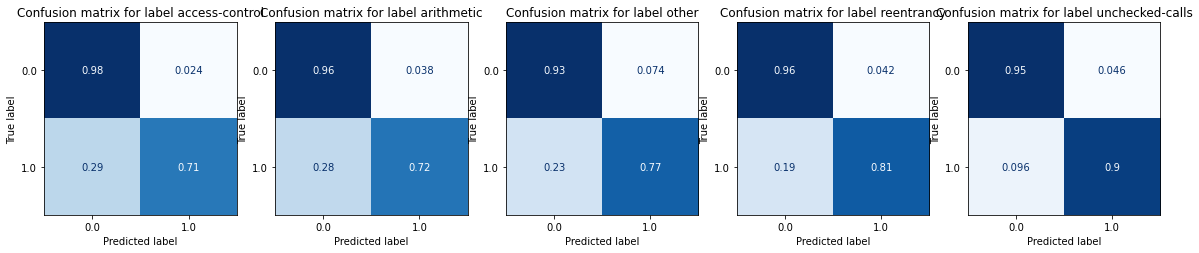

In [41]:
_, axs = plt.subplots(1, len(LABEL_NAMES), figsize=(25, 10))
conf_mat_dict={}

for label_col, ax in zip(range(len(LABEL_NAMES)), axs):
    y_true_label = y_true[:, label_col]
    y_pred_label = y_pred[:, label_col]
    ax.set_title("Confusion matrix for label " + LABEL_NAMES[label_col])
    ConfusionMatrixDisplay.from_predictions(y_true_label, y_pred_label, ax=ax, cmap=plt.cm.Blues, normalize='true', colorbar=False)

plt.show()